In [1]:
%matplotlib inline
import os
import sys
import inspect
import matplotlib.pyplot as plt
import PIL

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from autocrop import Cropper

LOC = 'data/obama.jpg'

## Setup the `Cropper` instance

In [2]:
# Very simple. Simply create an instance of the object and specify your settings
c = Cropper(width=500, height=500)

## Crop the face

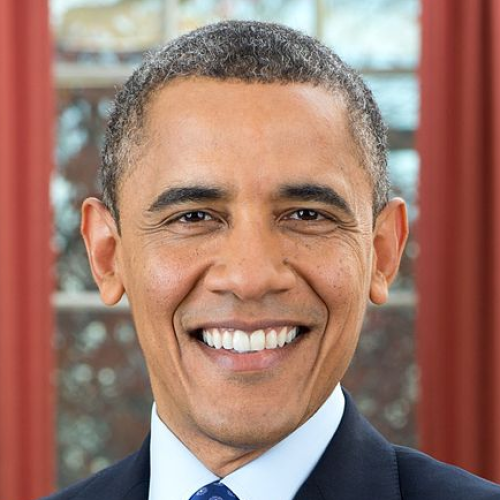

In [3]:
# The crop method returns an np.array, by default 500x500 px
img_array = c.crop(LOC)

# We can display it in this notebook with PIL
PIL.Image.fromarray(img_array)

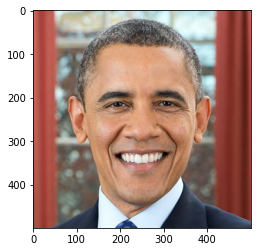

In [4]:
# You can also show the np.array with Matplotlib
plt.imshow(img_array)

In [5]:
%%timeit
# Autocrop somewhat favours performance over precision. A single image 
# takes about 32ms on 2016 i7 5-series, 148ms on 10 yo MBP
img_array = c.crop(LOC)

38.1 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


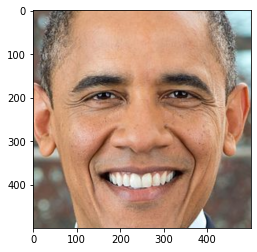

In [6]:
# Use the `face_percent` parameter to set the framing. Think of it as a zoom.
c = Cropper(face_percent=100)
plt.imshow(c.crop(LOC))

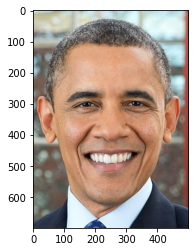

In [7]:
c = Cropper(width=500, height=700)
plt.imshow(c.crop(LOC))

In [8]:
# No faces detected returns None
noise = 'data/noise.png'
assert c.crop(noise) is None

And here's the full class documentation

In [17]:
help(Cropper)

Help on class Cropper in module autocrop.autocrop:

class Cropper(builtins.object)
 |  Cropper(width=500, height=500, face_percent=50, padding=None, fix_gamma=True)
 |  
 |  Crops the largest detected face from images.
 |  
 |  This class uses the `CascadeClassifier` from OpenCV to
 |  perform the `crop` by taking in either a filepath or
 |  Numpy array, and returning a Numpy array. By default,
 |  also provides a slight gamma fix to lighten the face
 |  in its new context.
 |  
 |  Parameters:
 |  -----------
 |  
 |  * `width` : `int`, default=500
 |      - The width of the resulting array.
 |  * `height` : `int`, default=`500`
 |      - The height of the resulting array.
 |  * `face_percent`: `int`, default=`50`
 |      - Aka zoom factor. Percent of the overall size of
 |      the cropped image containing the detected coordinates.
 |  * `fix_gamma`: `bool`, default=`True`
 |      - Cropped faces are often underexposed when taken
 |      out of their context. If under a threshold, se

## Save cropped image to file

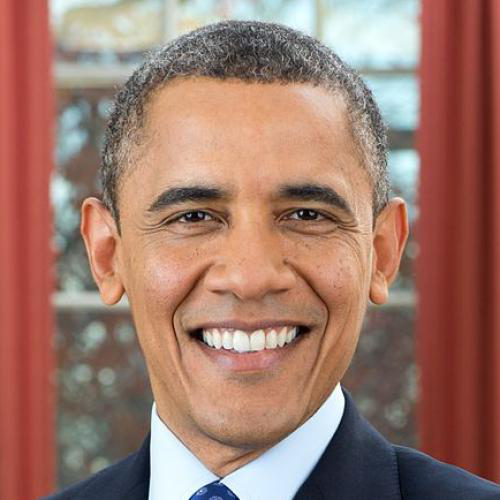

In [9]:
# To save the image array, simply use the PIL interface
image = PIL.Image.fromarray(img_array)

SAVE_AS_PATH = 'asdf.jpg'
image.save(SAVE_AS_PATH)
PIL.Image.open(SAVE_AS_PATH)

In [10]:
# Tear down that previous example
os.remove(SAVE_AS_PATH)

## Crop all images in a folder

In [11]:
from glob import glob
faces = [f for f in glob('data/*') if not f.endswith('md')]

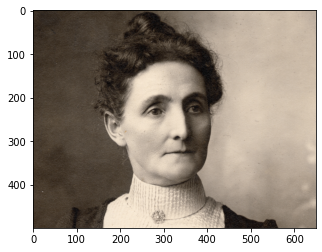

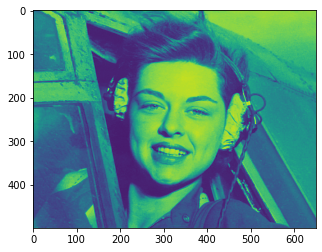

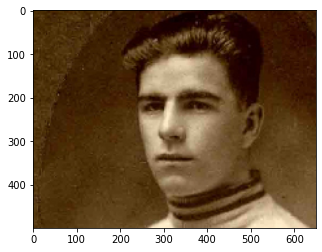

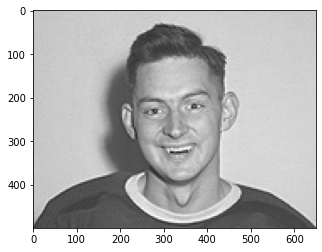

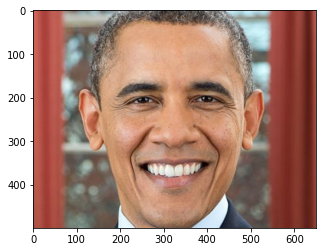

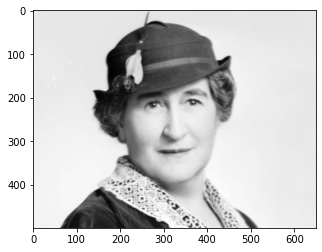

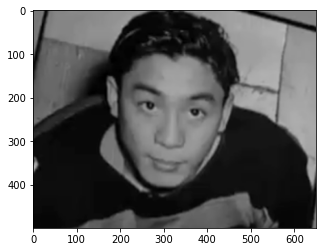

In [12]:
def plot_test_images(faces, cropper):
    """Given a list on filepaths, crops and plots them."""
    for face in faces:
        try:
            img_array = cropper.crop(face)
        except (AttributeError, TypeError):
            # If we don't detect a face, move on to the next one
            pass
        if img_array is not None:
            # You might want to save the image here instead
            plt.imshow(img_array)
            plt.show()

            
plot_test_images(faces, Cropper(width=650, height=500, face_percent=40))

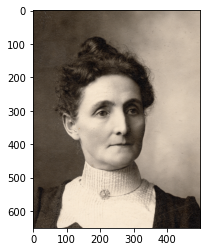

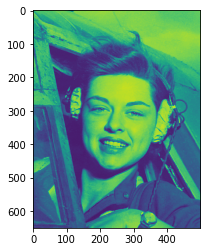

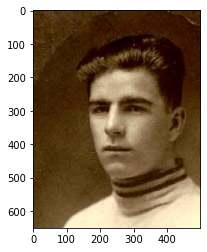

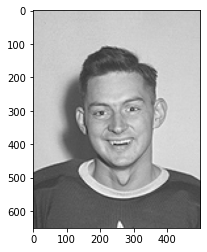

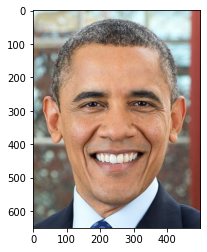

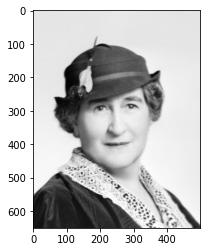

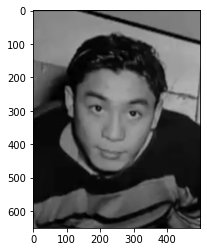

In [13]:
plot_test_images(faces, Cropper(height=650, width=500, face_percent=40))

## `Crop._crop_postions`

This internal method takes the coordinates of the detected face and attempts to crop it such that it honours the `face_percent` parameter. Sometimes though, the face is too close to the edge, so instead, it offers the largest image possible.

This might be useful to you in other situations.

Say we have a face that's detected in this box:

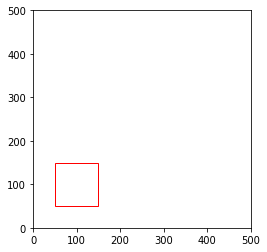

In [14]:
import matplotlib.patches as patches
from PIL import Image
import numpy as np

IMAGE_SIZE = (500, 500)
DETECTED_FACE = (50, 50, 100, 100)


def plot_square(width, height, x, y, w, h):
    """Plots a rectangle inside a rectangle"""
    ax = plt.axes(xlim=(0, width), ylim=(0, height))
    plt.gca().set_aspect('equal', adjustable='box')

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()
    
    
plot_square(*IMAGE_SIZE, *DETECTED_FACE)

This is too tight for a crop to occur that honours `face_percent`. Instead, we have to crop along the edge.

In [15]:
c = Cropper(face_percent=50)
crop_positions = c._crop_positions
print(help(crop_positions))
crop_coordinates = crop_positions(*IMAGE_SIZE, *DETECTED_FACE)
crop_coordinates

Help on method _crop_positions in module autocrop.autocrop:

_crop_positions(imgh, imgw, x, y, w, h) method of autocrop.autocrop.Cropper instance
    Retuns the coordinates of the crop position centered
    around the detected face with extra margins. Tries to
    honor `self.face_percent` if possible, else uses the
    largest margins that comply with required aspect ratio
    given by `self.height` and `self.width`.
    
    Parameters:
    -----------
    imgh: int
        Height (px) of the image to be cropped
    imgw: int
        Width (px) of the image to be cropped
    x: int
        Leftmost coordinates of the detected face
    y: int
        Bottom-most coordinates of the detected face
    w: int
        Width of the detected face
    h: int
        Height of the detected face

None


[0, 200, 0, 200]

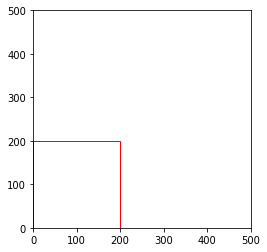

In [16]:
x_0, x_1, y_0, y_1 = crop_coordinates
plot_square(*IMAGE_SIZE, x_0, y_0, x_1 - x_0, y_1 - y_0)